# CMPINF 0010 Final Project
---
In this final project, our team has been tasked to find the best neighborhood in Pittsburgh through our own metrics.

DESCRIBE WHY WE CHOSE SAID METRICS

## Metric 1 - Arrest/Crime Data
---
One of the first metrics that our group thought of was safety, no matter what the benefits of a neighborhood are, if there is a high crime rate. In order to get measurable metric, we needed to import the Pittsburgh arrests CSV file and count the number of times a crime was committed in certian neighborhood in order to calculate crime rates for each neighborhood.

The first step is displayed below:

In [1]:
import pandas as pd
import geopandas
import matplotlib
import matplotlib.pyplot as plt 
%matplotlib inline
# the matplotlib inline allows you to display all graphs in Jupyter Notebooks
# the matplotlib.pyplot import allows you to manipulate plot, can use interface to generate plot

<AxesSubplot:>

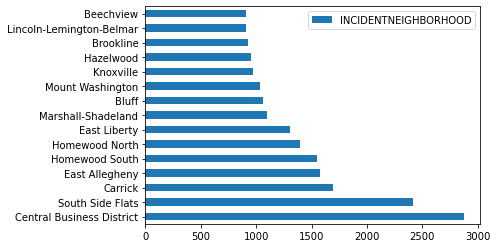

In [2]:
# create the initial read in file
arrestFile = pd.read_csv("CSVs/Arrests.csv")

# create a new DataFrame that counts the number of occurances of arrests by neighborhood
arrestsPerHood = pd.DataFrame(arrestFile["INCIDENTNEIGHBORHOOD"].value_counts(ascending = False))

# displays the data
arrestsPerHood.head(15).plot.barh()

After counting my data, we needed to import data from a separate CSV on population data for the neighborhoods in Pittsburgh so that we can merge the DataFrames and then calculate the crime rate.

In the population data, we encountered some varying ways of dsiplaying neighborhood names such as "Mount Oliver" and "Mount Oliver Borough." we first went through the data and changed the names to match eachother so that the DataFrames would contain both the proper arrests and population data. We did run into the name "Mt. Oliver Neighborhood", which was not as explicit about which neighborhood it was. We decided to categorize this into Mount Oliver as the "neighborhood" section of the name delineated this category from the borough.

The next steps are displayed in the following cell:

In [3]:
# reads in csv containing populations for neighborhoods
hoodInfo = pd.read_csv("CSVs/total-population.csv")

# the index/key of the number of occurances is the population name, but we want this as a column
# therefore, we reset the index of the dataframe so that the nieghborhoods is its own column
resetIndex = arrestsPerHood.reset_index()

# we rename the columns to properly describe the data
numArrests = resetIndex.rename(columns = {"INCIDENTNEIGHBORHOOD" : "numOfArrests", 
                                          "index" : "Neighborhood"})

# merge the number of arrests with the populations so that all neighborhoods 
# are paired with any existing arrest data and the rest are dropped
arrestAndPop = numArrests.merge(hoodInfo, how = "right", on = "Neighborhood").drop(columns = ["Id", "Margin of Error; Total"])

# rename the population column
arrestAndPop = arrestAndPop.rename(columns = {"Estimate; Total" : "Population"})

# display revised data
arrestAndPop.head()

,Neighborhood,numOfArrests,Population
0,Allegheny Center,864,1411.0
1,Allegheny West,92,343.0
2,Allentown,690,2558.0
3,Arlington,209,1852.0
4,Arlington Heights,111,272.0


Now that we had combined all of the data into one DataFrame, we needed to find the crime rate for each neighborhood so that the data is standardized. With the merged data, we can divide the number of arrests by the population and multiply by 1,000 to find the crime rate per 1,000 people.

The steps are below:

In [4]:
# create new column with crime rate calculation
arrestAndPop["Crime_Ratio"] = arrestAndPop["numOfArrests"] / arrestAndPop["Population"] * 1000

# display data
arrestAndPop.head() 

,Neighborhood,numOfArrests,Population,Crime_Ratio
0,Allegheny Center,864,1411.0,612.331680
1,Allegheny West,92,343.0,268.221574
2,Allentown,690,2558.0,269.741986
3,Arlington,209,1852.0,112.850972
4,Arlington Heights,111,272.0,408.088235


Now, we wanted to get a visual representation of the data to identify exactly where the neighborhoods with lower and higher crime rates are located. We did this by noting the coordinate reference system for the geographic coordinate system (longitude and latitude) and then reading the neighborhoods shape file from the WPRDC and setting the file to the proper CRS.

After changing the CRS I need to merge the arrest and population DataFrame with the shape file so that the neighborhoods have a crime ratio column. We can then plot the chloropleth map. For our scale we had to normalize the data on a logarithmic scale because if we did not, the majority of the neighborhoods would be a very similar color because some neighborhoods had extremly high crime rates compared to others.

It is important to note that the "Mount Oliver Borough" is not included in the neighborhoods shape file because it is not a neighborhood of Pittsburgh even though it was included in the arrests data. This is why when we merged the data, we merged with the `how` parameter set to "left."

The first chloropleth map is created below:

<AxesSubplot:>

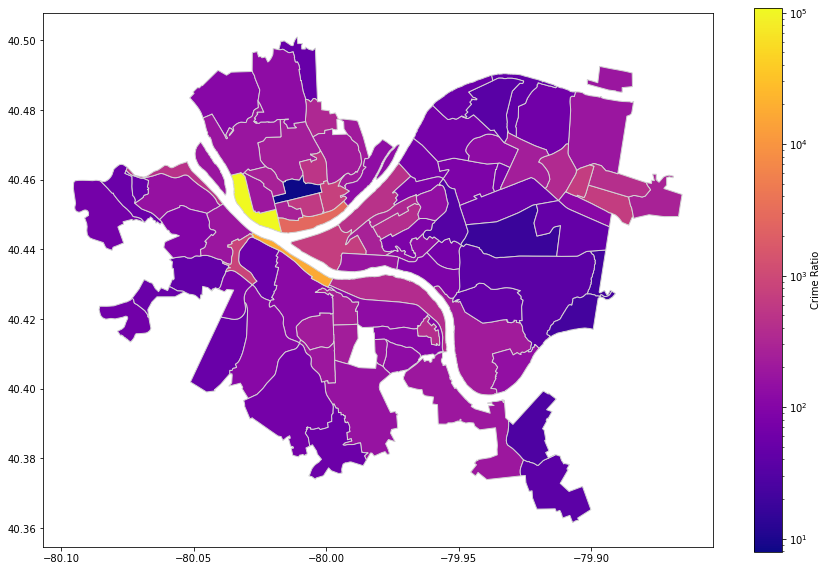

In [5]:
# crs for longitude and latitude
crs = "EPSG:4326"

# read in shape file for neighborhoods
neighborhoods = geopandas.read_file("Neighborhoods/Neighborhoods_.shp")

# convert coordinate system to longitude and latitude
neighborhoods = neighborhoods.to_crs(crs)

# merge the neighborhoods file for the map with crime rate data
crime_map = neighborhoods.merge(arrestAndPop, how = "left", left_on = "hood", 
                                right_on = "Neighborhood") 
#shape file MISSING MOUNT OLIVER BOROUGH MENTION THIS

# display map with my parameters
crime_map.plot(column="Crime_Ratio",
               cmap = "plasma",
               edgecolor = "lightgrey", 
               legend = True,
               legend_kwds = {"label" : "Crime Ratio"}, 
               figsize = (15, 10),
               norm = matplotlib.colors.LogNorm(vmin = crime_map['Crime_Ratio'].min(), vmax = crime_map['Crime_Ratio'].max())
              )

In the chloropleth maps, Chateau, North Shore, and South Shore had crime rates that were so large, it made it difficult to compare neighborhoods with lower crime rates against each other. Therefore, we decided to create another map with the three neighborhoods with the highest crime rates removed in order to obtain a better comparison among the other neighborhoods.

We did this by creating three querey masks for Chateau, North Shore, and South Shore and then combined them using the `&` operator to get the proper subset. After getting the new DataFrame, I can then merge with the neighborhood file and plot again as we did in with the previous map. The only difference is we added the `missing_kwds` parameter.

The second chloropleth map is created in the code cell below:

<AxesSubplot:>

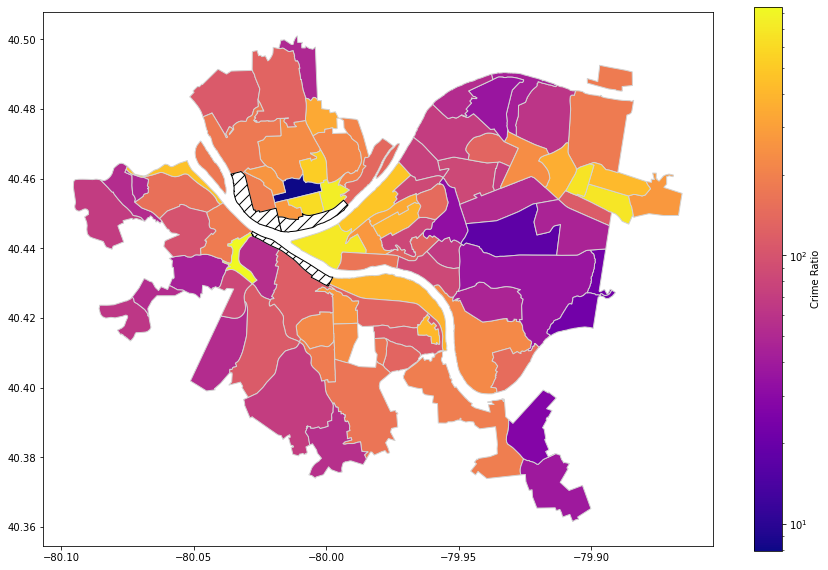

In [6]:
# create query masks for highest neighborhoods
query_mask1 = arrestAndPop["Neighborhood"] != "Chateau"
query_mask2 = arrestAndPop["Neighborhood"] != "South Shore"
query_mask3 = arrestAndPop["Neighborhood"] != "North Shore"

# filter the data. Have to use bitwise operators
lower_values = arrestAndPop[query_mask1 & query_mask2 & query_mask3]

# merge the removed data with the neighborhoods dataframe
lower_crime_map = neighborhoods.merge(lower_values, how = "left", left_on = "hood", right_on = "Neighborhood")

# plot the new data but signify what we removed
lower_crime_map.plot(column = "Crime_Ratio", 
                     cmap = "plasma",
                     edgecolor = "lightgrey",
                     legend = True,
                     legend_kwds = {"label" : "Crime Ratio"},
                     missing_kwds = {
                         "color" : "white",
                         "edgecolor" : "black",
                         "hatch" : "//"},
                     figsize = (15, 10),
                     norm = matplotlib.colors.LogNorm()
                    )

This chloropleth map allows us to better see the difference between the neighborhoods with lower crime rates.

I now wanted to find the top 3 neighborhood with the lowest crime rates. First I had to drop the row with Mount Oliver Borough because as previously mentioned, this is not a part of the city of Pittsburgh.

In [20]:
# 52 is the index of the Mount Oliver Borough 
finalCrime = arrestAndPop.drop([52])

# now list the crime rates
finalCrime.sort_values(by = "Crime_Ratio").head()

,Neighborhood,numOfArrests,Population,Crime_Ratio
18,Central Northside,23,2892.0,7.952974
76,Squirrel Hill North,198,11336.0,17.466478
66,Regent Square,23,1033.0,22.265247
82,Swisshelm Park,30,1345.0,22.304833
55,New Homestead,27,973.0,27.749229


In my dataset, I found that the top 3 neighborhoods with the lowest crime rates are:
1. Central Northside - 5.00
2. Squirrel Hill North - 17.47
3. Regent Square - 22.27

## Metric 2 - Older Housing Data 
---
Another metric that our group thought of was how old are the houses between the neighborhoods. Older housing is found to be unpleasant and also dangerous. 

Older houses with household lead paint and contaminated lead waters cause more exposure to lead which is a neurotoxin that can result in serious health problems, especially for pregnant women and children. It has been shown to affect IQ, ability to pay attention, academic achievement, and other behavioral issues.


In [8]:
#tract is the number of the tract 
#pre1950 represents the percent of homes in each census tract that were built on or before 1950
older_house_data = pd.read_csv("pre1950housing.csv")
older_house_data.head()

,TRACT,Pre1950
0,10300,0.658477
1,20100,0.321088
2,20300,0.724907
3,30500,0.324117
4,40200,0.463549


In [9]:
#neighborhoods corresponding the tract numbers
older_house_data = pd.read_csv("Pittsburgh_Census_Tracts_2010.csv")
older_house_data.head()

,Neighborhood,Census Tracts
0,Allegheny Center,562700
1,Allegheny West,562700
2,Allentown,180300
3,Arlington,561600
4,Arlington Heights,561600


In [10]:
#the data on percent venous confirmed elevated blood lead levels (EBLLs)(≥5 μg/dL)
#for Allegheny County children less than 6 years of ageby assigned geography for 2015-2019
lead_data = pd.read_csv("Blood_Lead_Level_Rates.csv")
lead_data.head()

,SchoolDistrict,percentEBLL2015,note2015,percentEBLL2016,note2016,percentEBLL2017,note2017,percentEBLL2018,note2018,percentEBLL2019,note2019,percentEBLL15_19,note15_19
0,Allegheny Valley,0.00,"Unstable percent, interpret with caution",0.00,"Unstable percent, interpret with caution",0.92,"Unstable percent, interpret with caution",0.68,"Unstable percent, interpret with caution",0.00,"Unstable percent, interpret with caution",0.43,"Unstable percent, interpret with caution"
1,Avonworth,0.72,"Unstable percent, interpret with caution",0.75,"Unstable percent, interpret with caution",0.55,"Unstable percent, interpret with caution",0.89,"Unstable percent, interpret with caution",2.00,"Unstable percent, interpret with caution",1.15,NaN
2,Baldwin-Whitehall,0.91,"Unstable percent, interpret with caution",0.59,"Unstable percent, interpret with caution",1.40,NaN,1.42,NaN,0.49,"Unstable percent, interpret with caution",1.05,NaN
3,Bethel Park,0.00,"Unstable percent, interpret with caution",0.00,"Unstable percent, interpret with caution",0.61,"Unstable percent, interpret with caution",0.18,"Unstable percent, interpret with caution",0.89,"Unstable percent, interpret with caution",0.51,"Unstable percent, interpret with caution"
4,Brentwood Borough,1.60,"Unstable percent, interpret with caution",1.35,"Unstable percent, interpret with caution",3.45,"Unstable percent, interpret with caution",2.68,"Unstable percent, interpret with caution",2.54,"Unstable percent, interpret with caution",2.46,NaN


## Metric 3 - 
---

## Conclusion
---